In [51]:
import numpy as np
from gridworld import GridWorld
import matplotlib.pyplot as plt
import torch
import os.path as osp
import random
from typing import Dict,List
import gym.spaces as spaces
import hydra
import numpy as np
from typing import Tuple
import yaml
from collections import defaultdict
from typing import Dict, Optional

from torchrl.envs.utils import step_mdp
from hydra.utils import instantiate as hydra_instantiate
from omegaconf import DictConfig, OmegaConf
from rl_utils.common import (Evaluator, compress_dict, get_size_for_space,
                             set_seed)
from rl_utils.envs import create_vectorized_envs
from rl_utils.logging import Logger
from tensordict.tensordict import TensorDict


In [11]:
import sys
sys.path.append("/Users/williamhuang/Documents/Projects/Tobin 2024/Code/code/bc-irl-main") 

from imitation_learning.policy_opt.policy import Policy
from imitation_learning.policy_opt.ppo import PPO
from imitation_learning.policy_opt.storage import RolloutStorage

In [12]:
world=\
    """
    wwwwww
    wa   w
    w    w
    w    w
    w   gw
    wwwwww
    """
    
env=GridWorld(world,slip=0) # Slip is the degree of stochasticity of the gridworld.

# Value Iteration
V=np.zeros((env.state_count,1))
V_prev=np.random.random((env.state_count,1))
eps=1e-7
gamma=0.9

while np.abs(V-V_prev).sum()>eps:
    Q_sa=env.R_sa+gamma*np.squeeze(np.matmul(env.P_sas,V),axis=2)
    V_prev=V.copy()
    V=np.max(Q_sa,axis=1,keepdims=True)
    pi=np.argmax(Q_sa,axis=1)

print("Pi:",pi)
env.show(pi)  # Show the policy in graphical window and we can control the agent using the arrow-keys

Pi: [0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0]


2024-11-06 22:20:38.995 python[98405:6390659] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-06 22:20:38.995 python[98405:6390659] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [13]:
print(env.observation_space)

Discrete(16)


In [14]:
value_grid = V.reshape(4, 4)
print("Value Function V(s):\n", value_grid)

Value Function V(s):
 [[586.39489995 652.66099995 726.28999995 808.09999995]
 [652.66099995 726.28999995 808.09999995 898.99999995]
 [726.28999995 808.09999995 898.99999995 999.99999995]
 [808.09999995 898.99999995 999.99999995 999.99999995]]


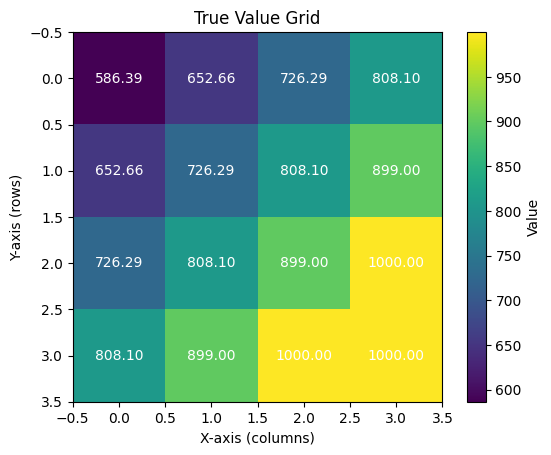

In [15]:
# Create the heatmap
plt.imshow(value_grid, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Value")

# Annotate each cell with its value
for i in range(value_grid.shape[0]):
    for j in range(value_grid.shape[1]):
        plt.text(j, i, f"{value_grid[i, j]:.2f}", ha="center", va="center", color="white")

# Label and show the plot
plt.title("True Value Grid")
plt.xlabel("X-axis (columns)")
plt.ylabel("Y-axis (rows)")
plt.show()

In [26]:
def set_seed(seed: int) -> None:
    """
    Sets the seed for numpy, python random, and pytorch.
    """
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [54]:

import gymnasium as gym
import numpy as np
import pygame as pg
from collections import deque
from gym.spaces import Box,Discrete
from collections import defaultdict
from gridworld.modules import Agent, Wall, Goal, State, Hole, Block

class GridWorld(gym.Env):
    def __init__(self,world=world,slip=0.2,log=False,max_episode_step=1000,blocksize=(50,50),isDRL=False,viewsize=10,random_state=None):
        super().__init__()
        Block.setBlockSize(*blocksize)
        self.isDRL=isDRL
        if self.isDRL:Block.setViewSize(viewsize)
        self.seed=random_state
        np.random.seed(random_state)

        self.world=world.split('\n    ')[1:-1]
        self.action_map={0:'right',1:'down',2:'left',3:'up'}
        self.action_values=[0,1,2,3]
        self.action_size=len(self.action_values)
        self.slip=slip
        self.logging=log
       
        self.col=len(self.world[0])
        self.row=len(self.world)
        self.state_color=(50,100,10)
        self.renderfirst=True
        self.policy={}
        self.episode_step=0
        self._max_epi_step=max_episode_step

        self.wall_group=pg.sprite.Group()
        self.state_group=pg.sprite.Group()
        self.state_dict=defaultdict(lambda :0)
        self.goal_group=pg.sprite.Group()

        i=0
        for y,et_row in enumerate(self.world):
            for x,block_type in enumerate(et_row):
                
                if block_type=='w':
                    self.wall_group.add(Wall(col=x,row=y))
                    
                elif block_type=='a':
                    self.agent=Agent(col=x,row=y,log=self.logging)
                    self.state_group.add(State(col=x,row=y,color=self.state_color))
                    self.state_dict[(x,y)]={'state':i,'reward':-1,'done':False,'type':'norm'}
                    i+=1
                    
                elif block_type=='g':
                    self.goal_group.add(Goal(col=x,row=y))
                    self.state_dict[(x,y)]={'state':i,'reward':100,'done':True,'type':'goal'}
                    i+=1

                elif block_type=='o':
                    self.state_group.add(Hole(col=x,row=y))
                    self.state_dict[(x,y)]={'state':i,'reward':-100,'done':True,"hole":True,'type':'hole'}
                    i+=1
                
                elif block_type==' ':
                    self.state_group.add(State(col=x,row=y,color=self.state_color))
                    self.state_dict[(x,y)]={'state':i,'reward':-1,'done':False,'type':'norm'}
                    i+=1
                    
        self.state_dict=dict(self.state_dict)
        self.state_count=len(self.state_dict)
        #setting action and observation space
        self.action_space=Discrete(self.action_size)
        if self.isDRL:
            self.observation_space=Box(low=-2,high=2,shape=((2*viewsize+1)*(2*viewsize+1),),dtype='int8')
        else:
            self.observation_space=Discrete(self.state_count)
        #building environment model
        self.P_sas, self.R_sa=self.build_Model(self.slip)
        self.reset()


    def random_action(self):
        return np.random.choice(self.action_values)


    def formatState(self,response_state):
        if self.isDRL:
            return self.agent.getViewState(self.state_dict).flatten()
        else:
            return response_state
    

    def reset(self):
        self.episode_step=0
        self.agent.reInitilizeAgent()
        return self.formatState(self.state_dict[(self.agent.initial_position.x,self.agent.initial_position.y)]['state'])
    

    def get_action_with_probof_slip(self,action):
        individual_slip=self.slip/3
        prob=[individual_slip for a in self.action_values]
        prob[action]=1-self.slip
        act=np.random.choice(self.action_values,p=prob)
        return act

    
    def step(self,action,testing=False):
        if not testing:
            action=self.get_action_with_probof_slip(action)
        action=self.action_map[action]
        response=self.agent.move(action,self.wall_group,self.state_dict)
        self.episode_step+=1
        if "hole" in response:
            return self.formatState(response['state']),response['reward'],response['done'],{"hole":True}
        elif self.episode_step<=self._max_epi_step:
            return self.formatState(response['state']),response['reward'],response['done'],{}
        else:
            return self.formatState(response['state']),response['reward'],True,{'TimeLimit':True}
    

    def render(self):
        if self.renderfirst:
            pg.init()
            self.screen = pg.display.set_mode((self.col*Block.sizeX,self.row*Block.sizeY))
            self.renderfirst=False
        self.screen.fill(self.state_color)
        self.wall_group.draw(self.screen) 
        self.state_group.draw(self.screen)
        self.goal_group.draw(self.screen)    
        self.agent.draw(self.screen)
        pg.display.update()
        pg.display.flip()
        
    
    def close(self):
        self.renderfirst=True
        pg.quit()
        
        
    def __setPolicy(self,policy):
        for i,act in enumerate(policy):
            self.policy[i]=self.action_map[act]
        for s in self.state_group:
            s.change_with_policy(self.state_dict,self.policy)
    
    def __unsetPolicy(self):
        self.policy={}
        for s in self.state_group:
            s.default_state()
        
    def play_as_human(self,policy=None):
        if policy is not None:
            self.__setPolicy(policy)

        pg.init()
        screen = pg.display.set_mode((self.col*Block.sizeX,self.row*Block.sizeY))
        clock = pg.time.Clock()
        done = False
        while not done: 
            for event in pg.event.get():
                    if event.type == pg.QUIT:
                        done = True
                    elif event.type == pg.KEYDOWN:
                        if event.key == pg.K_LEFT:
                            response=self.agent.move('left',self.wall_group,self.state_dict)
                        elif event.key == pg.K_RIGHT:
                            response=self.agent.move('right',self.wall_group,self.state_dict)
                        elif event.key == pg.K_UP:
                            response=self.agent.move('up',self.wall_group,self.state_dict)
                        elif event.key == pg.K_DOWN:
                            response=self.agent.move('down',self.wall_group,self.state_dict)
                        if self.isDRL:self.formatState(response['state'])

            screen.fill(self.state_color)

            self.wall_group.draw(screen)  
            self.state_group.draw(screen)
            self.goal_group.draw(screen)    
            self.agent.draw(screen)
            
            pg.display.update()
            pg.display.flip()
            clock.tick(60)
        self.__unsetPolicy()
        pg.quit()

    def getScreenshot(self,policy=None):
        if policy is not None:
            self.__setPolicy(policy)
        pg.init()
        screen = pg.display.set_mode((self.col*Block.sizeX,self.row*Block.sizeY))
        screen.fill(self.state_color)

        self.wall_group.draw(screen)  
        self.state_group.draw(screen)
        self.goal_group.draw(screen)    
        self.agent.draw(screen)
        
        pg.display.update()
        pg.display.flip()
        image=pg.surfarray.array3d(screen).transpose(1,0,2)
        self.__unsetPolicy()
        pg.quit()
        return image

    
    def show(self,policy):
        self.play_as_human(policy)


    def build_Model(self,slip):
        P_sas=np.zeros((self.state_count,self.action_size,self.state_count),dtype="float32")
        R_sas=np.zeros((self.state_count,self.action_size,self.state_count),dtype="float32")

        for (col,row), curr_state in self.state_dict.items():
            for act in self.action_values:
                action=self.action_map[act]
                self.agent.setLoc(col,row)
                next_state=self.agent.move(action,self.wall_group,self.state_dict)
                P_sas[curr_state["state"],act,next_state["state"]]=1.0
                R_sas[curr_state["state"],act,next_state["state"]]=next_state["reward"]

        correct=1-slip
        ind_slip=slip/3
        for a in self.action_values:
            other_actions=[oa for oa in self.action_values if oa!=a]
            P_sas[:,a,:]=(P_sas[:,a,:]*correct)+(P_sas[:,other_actions,:].sum(axis=1)*ind_slip)

        R_sa=np.multiply(P_sas,R_sas).sum(axis=2)
        return P_sas,R_sa


class ractGridWorld(gym.Env):
    def __init__(self,world,slip=0.2,log=False,max_episode_step=1000,blocksize=(50,50),isDRL=False,viewsize=10,random_state=None,repeat_act=4):
        super().__init__()
        self.repeat_act=repeat_act
        self.state=deque([],maxlen=repeat_act)
        self.env=GridWorld(world,slip,log,max_episode_step,blocksize,isDRL,viewsize,random_state)
        self.observation_space=Box(low=self.env.observation_space.low.min(),high=self.env.observation_space.high.max(),
        shape=(self.env.observation_space.shape[0]*repeat_act,),dtype='int8')
        self.action_space=self.env.action_space
    
    def get_state(self):
        return np.array(self.state,dtype='int8').flatten()

    def reset(self):
        s=self.env.reset()
        for i in range(self.repeat_act):
            self.state.append(s)
        return self.get_state()
    
    def step(self,action,testing=False):
        rewd=0
        for i in range(self.repeat_act):
            s,r,done,info=self.env.step(action,testing)
            self.state.append(s)
            rewd+=r
            if done:
                break
        return self.get_state(),rewd,done,info

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

In [56]:
set_seed(cfg.seed)
device = torch.device(cfg.device)

set_env_settings = {
    k: hydra_instantiate(v) if isinstance(v, DictConfig) else v
    for k, v in cfg.env.env_settings.items()
}
envs = create_vectorized_envs(
    cfg.env.env_name,
    cfg.num_envs,
    seed=cfg.seed,
    device=device,
    **set_env_settings,
)

TypeError: __init__() missing 1 required positional argument: 'world'

In [17]:
from gymnasium import Env
class vectorized_env():
    def __init__(self, envs : List[Env]):
        self.envs = envs
        self.num_envs = len(self.envs)
        self.observation_space = self.envs[0].observation_space
        self.action_space = self.envs[0].action_space

    def reset(self):

        return torch.tensor([env.reset()[0].tolist() for env in self.envs],dtype=torch.float32)
    
    def step(self, action) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, List[Dict]]:
        steps = [env.step(action[i]) for i,env in enumerate(self.envs)]
        return_value = (torch.tensor([step[0].tolist() for step in steps],dtype=torch.float32),
                torch.tensor([step[1] for step in steps],dtype=torch.float32),
                torch.tensor([step[2] for step in steps],dtype=torch.bool),
                [step[3] for step in steps])
        return return_value

In [18]:
cfg = yaml.load(open("bc-irl-mouse.yaml", 'r'), Loader=yaml.SafeLoader)
cfg = DictConfig(cfg)

In [25]:
set_seed(cfg.seed)
device = torch.device(cfg.device)

# Setup the environments
envs = vectorized_env([GridWorld(world, slip=0, isDRL=True) for _ in range(cfg.num_envs)])

steps_per_update = cfg.num_steps * cfg.num_envs

num_updates = int(cfg.num_env_steps) // steps_per_update

# Set dynamic variables in the config.
cfg.obs_shape = envs.observation_space.shape
cfg.action_dim = envs.action_space.n
cfg.action_is_discrete = isinstance(cfg.action_dim, spaces.Discrete)
cfg.total_num_updates = num_updates

logger: Logger = hydra_instantiate(cfg.logger, full_cfg=cfg)
print("policy",cfg.policy)
policy = hydra_instantiate(cfg.policy)
# policy = policy.to(device)
# print("policy_updater",cfg.policy_updater)
# updater = hydra_instantiate(cfg.policy_updater, policy=policy, device=device).to(device)

Assigning full prefix 116-3-vaepQh
policy {'_target_': 'imitation_learning.policy_opt.policy.Policy', 'hidden_size': 512, 'recurrent_hidden_size': 128, 'is_recurrent': False, 'obs_shape': [441], 'action_dim': 4, 'action_is_discrete': False, 'std_init': 0, 'num_envs': 256}


InstantiationException: Error in call to target 'imitation_learning.policy_opt.policy.Policy':
TypeError('empty(): argument \'size\' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got ListConfig"')
full_key: policy

In [20]:
import torch

# Load the model file
model_data = torch.load('bc-irl-main/traj/pm_100.pth')

# Print out the structure of the loaded model
print(model_data)


{'observations': tensor([[ 7.0711e-01,  7.0711e-01],
        [ 4.5711e-01,  4.5711e-01],
        [ 2.0711e-01,  2.0711e-01],
        [-4.5373e-03, -1.0177e-02],
        [ 1.7481e-03,  1.9880e-03],
        [-7.0711e-01,  7.0711e-01],
        [-4.5711e-01,  4.5711e-01],
        [-2.0711e-01,  2.0711e-01],
        [-4.3406e-03, -7.2082e-03],
        [ 1.6582e-03,  1.8090e-03],
        [-7.0711e-01, -7.0711e-01],
        [-4.5711e-01, -4.5711e-01],
        [-2.0711e-01, -2.0711e-01],
        [ 7.0889e-03,  1.2638e-02],
        [ 9.4061e-04,  5.1196e-04],
        [ 7.0711e-01, -7.0711e-01],
        [ 4.5711e-01, -4.5711e-01],
        [ 2.0711e-01, -2.0711e-01],
        [ 6.8596e-03,  9.9853e-03],
        [ 1.0217e-03,  6.7254e-04]]), 'actions': tensor([[-2.5935e+00, -2.6437e+00],
        [-1.7934e+00, -1.8345e+00],
        [-8.4658e-01, -8.6913e-01],
        [ 2.5141e-02,  4.8659e-02],
        [-1.7258e-03, -3.1513e-03],
        [ 2.5242e+00, -2.7202e+00],
        [ 1.7235e+00, -1.8424e+00]

/var/folders/wp/q7yyy4ls2m3bvyscgh359t0r0000gn/T/ipykernel_98405/1427147223.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load('bc-irl-main/traj/pm_